In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import os
import matplotlib.pyplot as plt
import random

In [2]:
# ==== Configuración general ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64  # Redimensionar a 64x64
nz = 100         # Tamaño del vector ruido (input del generador)
ngf = 64         # Tamaño del feature map en generador
ndf = 64        # Tamaño del feature map en discriminador
nc = 3           # Número de canales (1 para MNIST, 3 para CIFAR-10)

batch_size = 256
lr = 0.0002
beta1 = 0.5
num_epochs = 30
save_dir = 'D:/SIS-421/DATASET-VIDEOS/DCGAN/imgesGenerados'
os.makedirs(save_dir, exist_ok=True)

In [3]:
# ==== Transformaciones ====
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * nc, [0.5] * nc)
])

In [4]:
# ==== Dataset ====
dataset = ImageFolder(root='D:/SIS-421/DATASET-VIDEOS/DCGAN/dataset', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
# Función para mostrar imágenes de muestra
def show_sample_images(dataset, num_images=5):
    indices = random.sample(range(len(dataset)), num_images)  # Seleccionar índices aleatorios
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    class_names = dataset.classes  # Obtener nombres de clases
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Convertir tensor a numpy
        image = (image * 0.5) + 0.5  # Desnormalizar para mostrar colores reales
        axes[i].imshow(image)
        axes[i].set_title(f"Clase: {class_names[label]}")
        axes[i].axis("off")
    plt.show()

In [ ]:
show_sample_images(dataset)  # Mostrar imágenes de muestra antes de entrenar

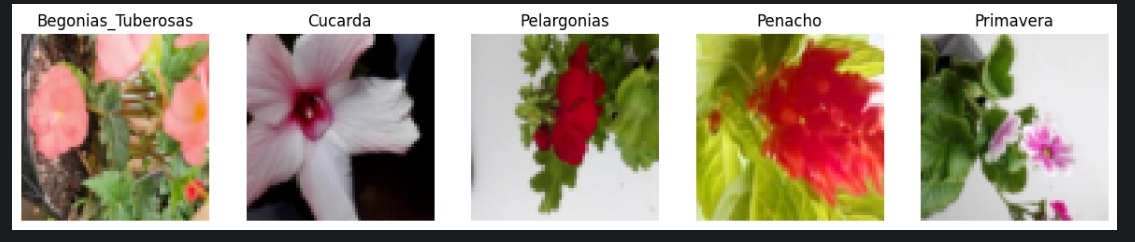

In [5]:
# ==== Generador ====
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [6]:
# ==== Discriminador ====
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

In [7]:
# ==== Inicializar modelos y optimizadores ====
G = Generator().to(device)
D = Discriminator().to(device)

In [8]:
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
# ==== Entrenamiento ====
G_losses, D_losses, D_accuracies = [], [], []

print("🚀 Entrenando DCGAN...")

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader): # Cargar imágenes reales
        real_images = real_images.to(device)
        b_size = real_images.size(0)
        label_real = torch.ones(b_size, device=device)
        label_fake = torch.zeros(b_size, device=device)

        # === Discriminador ===
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = G(noise)

        output_real = D(real_images)
        output_fake = D(fake_images.detach())

        loss_real = criterion(output_real, label_real)
        loss_fake = criterion(output_fake, label_fake)
        loss_D = loss_real + loss_fake

        optimizerD.zero_grad()
        loss_D.backward()
        optimizerD.step()

        # === Generador ===
        output = D(fake_images) # discriminador en modo evaluación
        loss_G = criterion(output, label_real)

        optimizerG.zero_grad()
        loss_G.backward()
        optimizerG.step()

        # === Métricas ===
        with torch.no_grad():
            acc_real = (output_real > 0.5).float().mean().item() #precision del discriminador en clasficar imágenes reales
            acc_fake = (output_fake < 0.5).float().mean().item()
            D_acc = 0.5 * (acc_real + acc_fake) # promedion de ambos resultados, que tan bien clasifica el discriminador

    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
    D_accuracies.append(D_acc)

    print(f"[{epoch+1}/{num_epochs}] Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}, D_acc: {D_acc:.4f}")

    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
    save_image(make_grid(fake, normalize=True), f"{save_dir}/epoch_{epoch+1:03d}.png")


🚀 Entrenando DCGAN...
[1/30] Loss_D: 1.4480, Loss_G: 2.2907, D_acc: 0.5400
[2/30] Loss_D: 0.5698, Loss_G: 3.0102, D_acc: 0.9125
[3/30] Loss_D: 0.5787, Loss_G: 3.4236, D_acc: 0.8900
[4/30] Loss_D: 0.5827, Loss_G: 2.7663, D_acc: 0.8875
[5/30] Loss_D: 0.6992, Loss_G: 2.0505, D_acc: 0.8375
[6/30] Loss_D: 1.0494, Loss_G: 5.1012, D_acc: 0.7225
[7/30] Loss_D: 0.5449, Loss_G: 4.0962, D_acc: 0.9275
[8/30] Loss_D: 0.5364, Loss_G: 2.5532, D_acc: 0.9050
[9/30] Loss_D: 0.5679, Loss_G: 2.9430, D_acc: 0.9550
[10/30] Loss_D: 0.3834, Loss_G: 3.3687, D_acc: 0.9800
[11/30] Loss_D: 0.4422, Loss_G: 3.1483, D_acc: 0.9725
[12/30] Loss_D: 0.3762, Loss_G: 3.5638, D_acc: 0.9700
[13/30] Loss_D: 0.6714, Loss_G: 5.3978, D_acc: 0.8475
[14/30] Loss_D: 0.2645, Loss_G: 3.7765, D_acc: 0.9875
[15/30] Loss_D: 0.3655, Loss_G: 4.7488, D_acc: 0.9900
[16/30] Loss_D: 1.0468, Loss_G: 8.2165, D_acc: 0.6500
[17/30] Loss_D: 0.1869, Loss_G: 4.0738, D_acc: 0.9975
[18/30] Loss_D: 0.3006, Loss_G: 2.8574, D_acc: 0.9925
[19/30] Loss_D:

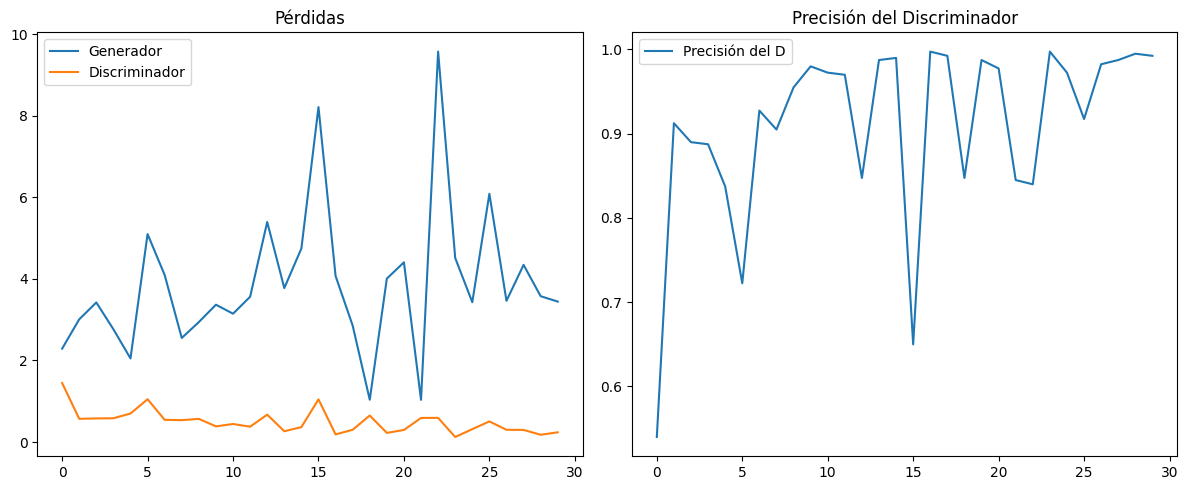

In [11]:
# ==== Graficar métricas ====
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(G_losses, label='Generador')
plt.plot(D_losses, label='Discriminador')
plt.title("Pérdidas")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(D_accuracies, label='Precisión del D')
plt.title("Precisión del Discriminador")
plt.legend()
plt.tight_layout()
plt.show()